# Final Submission
This notebook showcases the work done on the project. You can find the table of content in the left bar. Through the notebook we collect, explore and analyze the data to pick the most appropiate predictors to use in our models. Then we try plenty of models and approaches to get to the final model that allows us to accurately predict over 66% of stock prices.


We start with importing necessary libraries

In [ ]:
from sklearn.preprocessing import RobustScaler
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline
import torch
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import requests
from bs4 import BeautifulSoup
import os
from tqdm import tqdm
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score





# Problem Statement and Research

How does the sentiment of Yahoo financial news headlines influence fluctuations in the S&P 500 index, and to what extent can machine learning models like Linear Regression and Random Forest accurately predict these changes?
We aim to explore how the sentiment of financial news headlines affects daily fluctuations in the S&P 500 index. By analyzing and aligning news sentiment with stock data, we hope to reveal underlying patterns in how market responses reflect the tone of news coverage. As mini researchers, we will approach this problem from multiple angles, experimenting with various metrics, models and configurations. Ultimately, our goal is to identify an effective model that accurately predicts changes in the S&P 500 when given (sentiment analysis on) news headlines.

To validate out findings and explore the topic more we will also take into account other stock market indexes that are more industry speciifc. By this we hope to identify patterns and check whether specific types of companies stock market performance is more affected by the changing media sentiment and the level of confidence of media in the performnce of a sector.




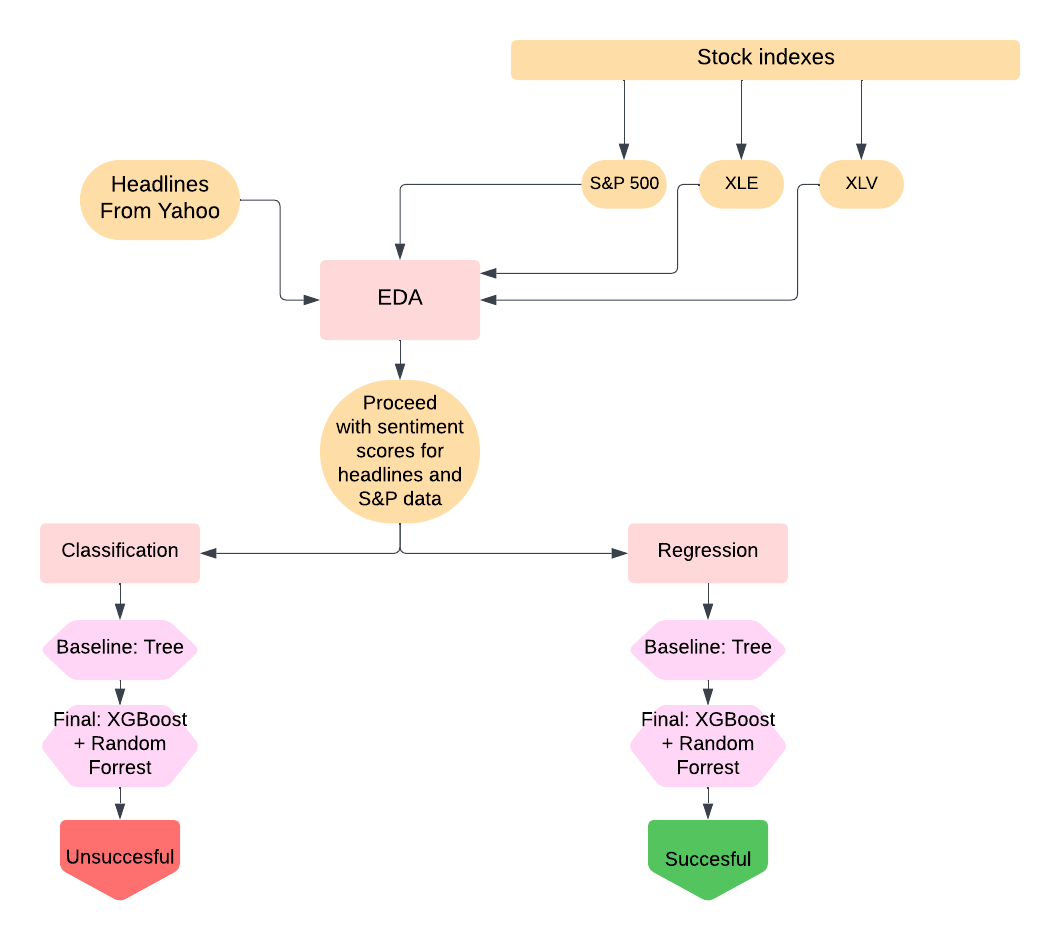

The flowchart above shows the process that is developed through the notebook. Each section is explaining each element in more detail, bu through the project we analyze data from Yahoo Finance and stock indexes, perform appropiate EDA and then try to predict both whether stocks go up or down (in classification models) and how will their values change(in regression models). In both parts of the analysis we try simplier model at first(a tree) and then, in hope to have more generalizable results a Random Forest.


# Data collection


##  S&P 500 Data

We start by collecting the S&P 500 index data usinf the Yahoo Finance library.

In [ ]:
# gets s&p 500 data using the yfinance library
sp500 = yf.Ticker("^GSPC")
start_date = "2022-01-01"
end_date = "2023-10-21"

data = sp500.history(start=start_date, end=end_date)


data = data[['Open', 'Close', 'High', 'Low', 'Volume']].reset_index()

data['Date'] = data['Date'].dt.date
# adds additional columns that how the volatility through the day
data['diffrence_open/close'] = data['Open'] - data['Close']
data['diffrence_high/low'] = data['High'] - data['Low']

print(data.head())
print(data.describe())

file_path = "sp500_data.csv"

data.to_csv(file_path, index=False)
print(f"Data saved to {file_path}")


         Date         Open        Close         High          Low      Volume  \
0  2022-01-03  4778.140137  4796.560059  4796.640137  4758.169922  3831020000   
1  2022-01-04  4804.509766  4793.540039  4818.620117  4774.270020  4683170000   
2  2022-01-05  4787.990234  4700.580078  4797.700195  4699.439941  4887960000   
3  2022-01-06  4693.390137  4696.049805  4725.009766  4671.259766  4295280000   
4  2022-01-07  4697.660156  4677.029785  4707.950195  4662.740234  4181510000   

   diffrence_open/close  diffrence_high/low  
0            -18.419922           38.470215  
1             10.969727           44.350098  
2             87.410156           98.260254  
3             -2.659668           53.750000  
4             20.630371           45.209961  
              Open        Close         High          Low        Volume  \
count   453.000000   453.000000   453.000000   453.000000  4.530000e+02   
mean   4157.141031  4156.800204  4186.344789  4125.292731  4.353321e+09   
std     265.

We also perform preprocessing on the S&P Data.

We start with checking for missing values.

In [ ]:
null_counts = data.isnull().sum()
print(null_counts)

Date                    0
Open                    0
Close                   0
High                    0
Low                     0
Volume                  0
diffrence_open/close    0
diffrence_high/low      0
dtype: int64


As we don't have any we check for duplicate rows and check the date range.

In [ ]:
df = data
duplicate_rows = df[df.duplicated()]
print("Number of duplicate rows:", duplicate_rows.shape[0])
date_min = df['Date'].min()
date_max = df['Date'].max()
print(f"Date range: {date_min} to {date_max}")

Number of duplicate rows: 0
Date range: 2022-01-03 to 2023-10-20


We also get plots and basic information about the data.


              Open        Close         High          Low        Volume  \
count   453.000000   453.000000   453.000000   453.000000  4.530000e+02   
mean   4157.141031  4156.800204  4186.344789  4125.292731  4.353321e+09   
std     265.380170   264.057932   261.071614   267.240138  8.754794e+08   
min    3520.370117  3577.030029  3608.340088  3491.580078  1.706460e+09   
25%    3957.179932  3957.250000  3979.199951  3925.030029  3.828150e+09   
50%    4132.240234  4136.279785  4157.689941  4107.310059  4.159470e+09   
75%    4380.939941  4384.649902  4412.600098  4356.290039  4.689970e+09   
max    4804.509766  4796.560059  4818.620117  4774.270020  9.354280e+09   

       diffrence_open/close  diffrence_high/low  
count            453.000000          453.000000  
mean               0.340827           61.052059  
std               44.099331           30.173203  
min             -149.539795           13.260010  
25%              -27.970215           38.919922  
50%                0.209

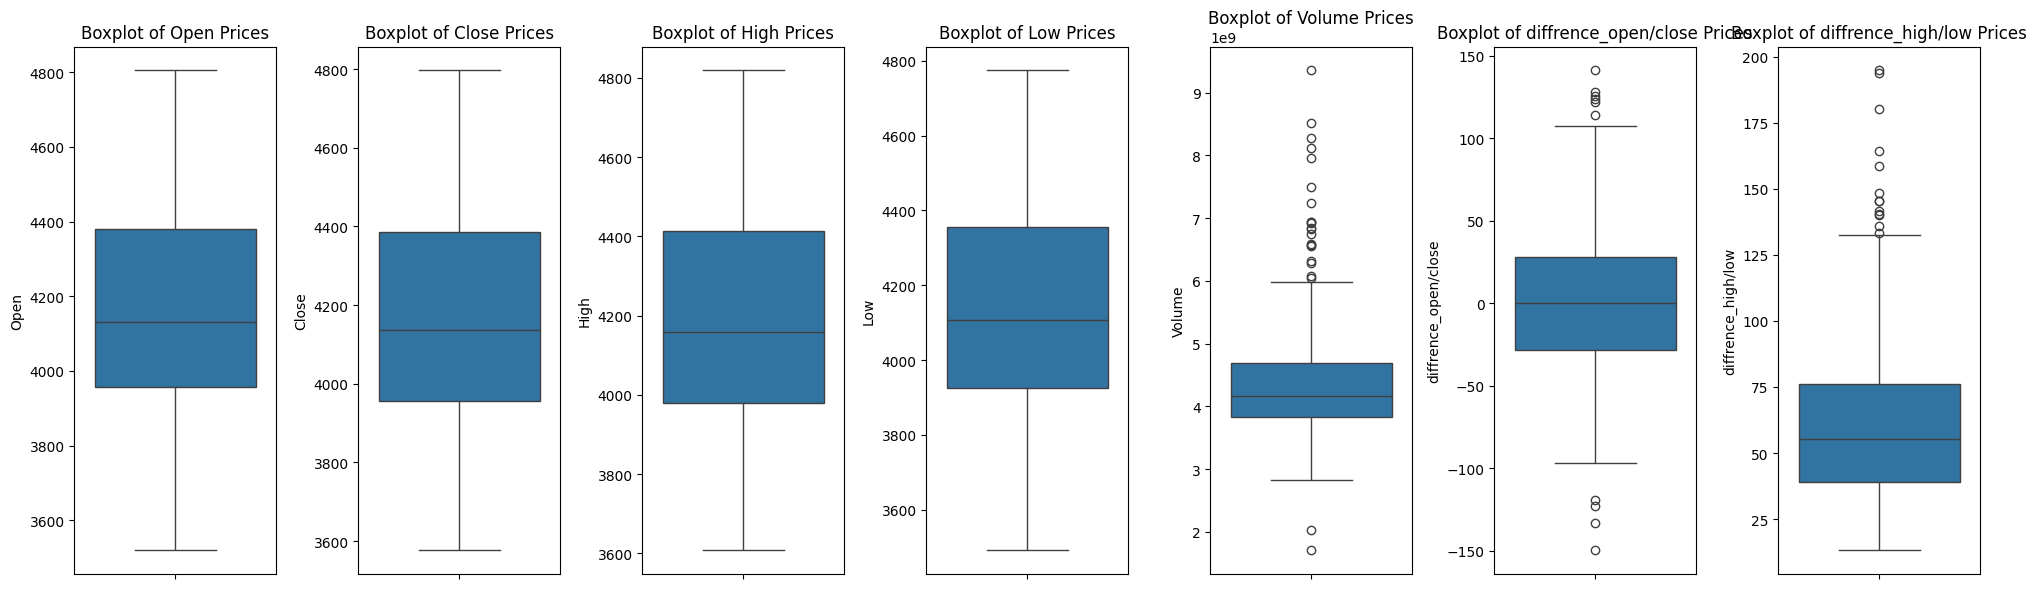

In [ ]:

print(df.describe())

columns_to_plot = ['Open', 'Close', 'High', 'Low', 'Volume','diffrence_open/close',
'diffrence_high/low']

num_columns = len(columns_to_plot)
fig, axes = plt.subplots(1, num_columns, figsize=(20, 6))

for ax, column in zip(axes, columns_to_plot):
    sns.boxplot(data=df[column], ax=ax)
    ax.set_title(f"Boxplot of {column} Prices")
    ax.set_ylabel(column)

plt.subplots_adjust(wspace=1.5)
plt.tight_layout()
plt.show()

Based on the bar plots, we can claim that we have a balanced distribution of days in which prices went up or down. This means there is no need to use over-sampling or under-sampling techniques to address imbalance.

Next, we appropriately scale the data.


In [ ]:
columns_to_scale = ['Open', 'Close', 'High', 'Low', 'Volume','diffrence_open/close',  'diffrence_high/low']

#  RobustScaler to the specified columns above (numerical values)
scaler = RobustScaler()
scaled_values = scaler.fit_transform(df[columns_to_scale])

df_scaled = pd.DataFrame(scaled_values, columns=columns_to_scale)
df_scaled['Date'] = df['Date'].values

df_scaled = df_scaled[['Date'] + columns_to_scale]
df_scaled.head()

,Date,Open,Close,High,Low,Volume,diffrence_open/close,diffrence_high/low
0,2022-01-03,1.524212,1.544877,1.474273,1.509205,-0.381112,-0.332616,-0.451838
1,2022-01-04,1.586439,1.537811,1.524988,1.546538,0.607667,0.192103,-0.294537
2,2022-01-05,1.547456,1.320310,1.476719,1.373023,0.845293,1.556861,1.147687
3,2022-01-06,1.324216,1.309710,1.308998,1.307679,0.157585,-0.051234,-0.043068
4,2022-01-07,1.334293,1.265209,1.269636,1.287924,0.025574,0.364583,-0.271534


After that we want to verify that we dont have missing data outisde of the weekends


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df['day_of_week'] = df['Date'].dt.dayofweek

# Create a date range for weekdays (Monday to Friday) from January 1, 2022, to October 20, 2023 (just business days)
all_weekdays = pd.date_range(start="2022-01-01", end="2023-10-20", freq='B')
missing_dates = all_weekdays.difference(df['Date'])

print(missing_dates)

df.to_csv('new_sp.csv', index=False)

DatetimeIndex(['2022-01-17', '2022-02-21', '2022-04-15', '2022-05-30',
               '2022-06-20', '2022-07-04', '2022-09-05', '2022-11-24',
               '2022-12-26', '2023-01-02', '2023-01-16', '2023-02-20',
               '2023-04-07', '2023-05-29', '2023-06-19', '2023-07-04',
               '2023-09-04'],
              dtype='datetime64[ns]', freq=None)


Results from the EDA show some interesting information about the stock market fluctuations. We want to analyze both the upward and downward trends related to stock market, as well the levels of volatility related to the market. This means that we will analyze both data on the level of closing/starting prices but also in terms of the differences between opening and closing and highest and lowest prices of the day.


## XLV and XLE data collection:

In an effort to determine if specfific (here, industry specific) indices are more significantly affected than the general S&P 500, we collect data for the XLE (energy industry) and XLV (health care industry) ETFs.

We use Yahoo finance to collect the data for both indices and preprocess it the same way we did for the s&p data. We then output 2 csv files for each, one containing the scaled data and one containing the unscaled data to allow for further exploration and different approaches to model construction.

In [ ]:

tickers = ["XLV", "XLE"]
start_date = "2022-01-03"
end_date = "2023-10-20"

df = df.add_prefix("SP500_")
df.rename(columns={"SP500_Date": "Date"}, inplace=True)  #

df_scaled = df_scaled.add_prefix("SP500_")
df_scaled.rename(columns={"SP500_Date": "Date"}, inplace=True)


unscaled_combined = df.copy()
scaled_combined = df_scaled.copy()


# loop through tickers
for ticker in tickers:

    etf = yf.Ticker(ticker)
    data = etf.history(start=start_date, end=end_date)


    data = data[['Open', 'Close', 'High', 'Low', 'Volume']].reset_index()
    data['Date'] = data['Date'].dt.date


    data['difference_open_close'] = data['Open'] - data['Close']
    data['difference_high_low'] = data['High'] - data['Low']

  # based on the dates that were not in s&p
    dates_to_remove = [
        '2022-01-17', '2022-02-21', '2022-04-15', '2022-05-30',
        '2022-06-20', '2022-07-04', '2022-09-05', '2022-11-24',
        '2022-12-26', '2023-01-02', '2023-01-16', '2023-02-20',
        '2023-04-07', '2023-05-29', '2023-06-19', '2023-07-04',
        '2023-09-04'
    ]
    dates_to_remove = pd.to_datetime(dates_to_remove)
    data['Date'] = pd.to_datetime(data['Date'])
    data = data[~data['Date'].isin(dates_to_remove)]


    data_with_prefix = data.add_prefix(f"{ticker}_")
    data_with_prefix.rename(columns={f"{ticker}_Date": "Date"}, inplace=True)

    unscaled_combined['Date'] = pd.to_datetime(scaled_combined['Date'], errors='coerce')


    unscaled_combined = pd.merge(unscaled_combined, data_with_prefix, on="Date", how="outer")

    # scale
    scaler = RobustScaler()
    scaled_columns = [f"{ticker}_Open", f"{ticker}_Close", f"{ticker}_High", f"{ticker}_Low", f"{ticker}_Volume",
                      f"{ticker}_difference_open_close", f"{ticker}_difference_high_low"]
    data_with_prefix[scaled_columns] = scaler.fit_transform(data_with_prefix[scaled_columns])


    scaled_combined['Date'] = pd.to_datetime(scaled_combined['Date'], errors='coerce')
    data_with_prefix['Date'] = pd.to_datetime(data_with_prefix['Date'], errors='coerce')



    scaled_combined = pd.merge(scaled_combined, data_with_prefix, on="Date", how="outer")

# Save the combined unscaled and scaled DataFrames
unscaled_combined.to_csv("combined_unscaled_data.csv", index=False)
scaled_combined.to_csv("combined_scaled_data.csv", index=False)





## Webscraping from Yahoo Finance


Financial news headlines are scraped from
the Yahoo Finance website using Python libraries like BeautifulSoup and Requests. The headlines are scraped over a period of the last two years to ensure a sufficient dataset. Each headline includes the date and time of publication to align it with stock market data.



In [ ]:
start_date = datetime(2022, 1, 1)
end_date = datetime(2023, 10, 21)

yahoo_dates = []
r_dates = []

current_date = start_date
while current_date <= end_date:
    yahoo_dates.append(current_date.strftime("%Y_%m_%d"))
    r_dates.append(current_date.strftime("%Y-%m/%d"))
    current_date += timedelta(days=1)

reuters_dates = [f"{d}/{i}/" for i in range(1,6) for d in r_dates]

Extractions from yahoo


In [ ]:
def extract_text_yahoo(date):
    try:
        response = requests.get(f"https://finance.yahoo.com/sitemap/{date}")
        response.raise_for_status()

        soup = BeautifulSoup(response.content, 'html.parser')

        texts = [element.get_text() for element in soup.find_all('a', class_="Td(n) Td(u):h C($c-fuji-grey-k) Fz(16px) Ta(start) Mb(20px) D(b) Cur(p) Wow(bw)")]

        return texts
    except requests.exceptions.RequestException as e:
        print(f"Error fetching yahoo url for date {date}: {e}")
        return []

In [ ]:
df_headlines_data = pd.DataFrame(columns=['headline', 'date', 'source'])

for date in tqdm(yahoo_dates, desc="Processing dates"):
    headlines = extract_text_yahoo(date)
    temp_df = pd.DataFrame({
        'headline': headlines,
        'date': date.replace("_", "-"),
        'source': 'Yahoo'
    })
    df_headlines_data = pd.concat([df_headlines_data, temp_df], ignore_index=True)

Processing dates: 100%|██████████| 659/659 [05:55<00:00,  1.85it/s]


In [ ]:
df_headlines_data.to_csv('yahoo_headlines.csv', index=False)

To ensure balance with the S&P 500 we delete the articles from the days with non reported S&P values.

In [ ]:
dates_remove=['2022-01-17', '2022-02-21', '2022-04-15', '2022-05-30','2022-06-20', '2022-07-04', '2022-09-05', '2022-11-24', '2022-12-26', '2023-01-02', '2023-01-16', '2023-02-20', '2023-04-07', '2023-05-29', '2023-06-19', '2023-07-04', '2023-09-04', '2023-11-23', '2023-12-25', '2024-01-01',  '2024-01-15', '2024-02-19', '2024-03-29', '2024-05-27',  '2024-06-19', '2024-07-04', '2024-09-02']
df = df_headlines_data
df_filtered = df[~df['date'].isin(dates_remove)]

df_filtered.to_csv('yahoo_headlines_filtered.csv', index=False)


## Calculting sentiments from the headlines

To perform sentiment analysis, we used Python libraries designed to assess the positive, neutral, or negative tone of the headlines. Initially, we tested TextBlob and NLTK, but we found that most Yahoo Finance headlines are written to convey information rather than emotion. As a result, nearly all headlines were classified as "neutral," which significantly reduced sentiment variation in our dataset and made it difficult to draw meaningful conclusions. This led us to switch to the FinBERT model from HuggingFace's Transformers library. FinBERT proved more effective at capturing subtle sentiments in the headlines and also provided confidence scores, which indicate how strongly the program "feels" about the detected sentiment.


In [ ]:
# 0 for GPU, -1 for CPU
device = 0 if torch.cuda.is_available() else -1

# FinBERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained("yiyanghkust/finbert-tone")
model = BertForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")


finbert_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device=device)

data = pd.read_csv("yahoo_headlines_filtered.csv")

sample_data = data

sample_data["sentiment"] = sample_data["headline"].apply(lambda x: finbert_pipeline(x)[0]["label"])
sample_data["confidence"] = sample_data["headline"].apply(lambda x: finbert_pipeline(x)[0]["score"])

print (sample_data)

sample_data.to_csv("yahoo_headlines_with_sentiment.csv", index=False)

print("Sentiment analysis complete. Results saved to yahoo_headlines_with_sentiment.csv")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


                                                headline        date source  \
0      Shiba Inu and 9 More of the Biggest Hits in Cr...  2022-01-01  Yahoo   
1                        27 Ugly Truths About Retirement  2022-01-01  Yahoo   
2      How Much You Need To Be ‘Rich’ in 50 Major US ...  2022-01-01  Yahoo   
3      Upcoming Deadline Reminder: The Schall Law Fir...  2022-01-01  Yahoo   
4      Upcoming Deadline Reminder: The Schall Law Fir...  2022-01-01  Yahoo   
...                                                  ...         ...    ...   
31144  Longtime Ansonian Ruth Waddell Hickman remembered  2023-10-21  Yahoo   
31145  Marion County Public Library bolsters science ...  2023-10-21  Yahoo   
31146  Youngstown names Creative Structure Services p...  2023-10-21  Yahoo   
31147  Alaska Air adds summer nonstop flights from An...  2023-10-21  Yahoo   
31148  Albuquerque Development Commission recommends ...  2023-10-21  Yahoo   

      sentiment  confidence  
0       Neutral    0.

This allows us to get the sentiments of each of the headlines.


## Calcuting the average weigh and stdev per day

To discover patterns, we calculated an average sentiment per day, measured as the weighted average of sentiment values. The sentiment values are defined as  weight_of_sentiment * confidence. We assigned a weight of 1 to positive sentiments, 0 to neutral, and -1 to negative, resulting in a range of scores from -1 to 1. We also calculated the standard deviation of the sentiments


In [ ]:
# Read the data
data = pd.read_csv("yahoo_headlines_with_sentiment.csv")
sample_data = data

# Function to assign weights based on sentiment
def get_weight(sentiment):
    if sentiment == "Positive":
        return 1  # More emphasis on non-neutral
    elif sentiment == "Negative":
        return -1  # More emphasis on non-neutral
    else:
        return 0

# Apply the weight calculation
sample_data["weight"] = sample_data["sentiment"].apply(get_weight)
sample_data["weighted_score"] = sample_data["confidence"] * sample_data["weight"]

# Calculate the weighted average and standard deviation per day
stats_per_day = sample_data.groupby("date").apply(
    lambda x: pd.Series({
        "weighted_avg_score": x["weighted_score"].sum() / len(x),
        "weighted_score_stdev": x["weighted_score"].std()  # Calculate standard deviation
    })
).reset_index()

# Display the results
print(stats_per_day)

stats_per_day.to_csv("stats_per_days.csv", index=False)

           date  weighted_avg_score  weighted_score_stdev
0    2022-01-01            0.039985              0.197874
1    2022-01-02            0.261937              0.446975
2    2022-01-03            0.240848              0.666200
3    2022-01-04            0.107028              0.552467
4    2022-01-05           -0.054567              0.602219
..          ...                 ...                   ...
618  2023-10-17            0.103228              0.539416
619  2023-10-18           -0.002329              0.634856
620  2023-10-19           -0.101901              0.556442
621  2023-10-20            0.023350              0.582386
622  2023-10-21            0.024390              0.512190

[623 rows x 3 columns]


<ipython-input-15-e05acd4f3d16>:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stats_per_day = sample_data.groupby("date").apply(




## Merging stats of sentiment with scaled and unscaled combined datasets


In [ ]:
scaled_combined['Date'] = pd.to_datetime(scaled_combined['Date'])
unscaled_combined['Date'] = pd.to_datetime(unscaled_combined['Date'])
stats_per_day['date'] = pd.to_datetime(stats_per_day['date'])

datasets = {
    "scaled_combined": scaled_combined,
    "unscaled_combined": unscaled_combined
}

# Process and save each dataset
for name, data in datasets.items():
    # Merge the data with stats_per_day
    merged_data = pd.merge(data, stats_per_day, left_on="Date", right_on="date", how="left")

    # Rename columns to match the required format
    merged_data.rename(columns={'SP500_diffrence_open/close': 'SP500_difference_open_close',
                                'SP500_diffrence_high/low': 'SP500_difference_high_low'}, inplace=True)

    # Add lagged columns
    for lag in range(1, 4):
        merged_data[f'SP500_Volume_{lag}ago'] = merged_data['SP500_Volume'].shift(lag)
        merged_data[f'SP500_difference_open_close_{lag}ago'] = merged_data['SP500_difference_open_close'].shift(lag)
        merged_data[f'SP500_Open_{lag}ago'] = merged_data['SP500_Open'].shift(lag)

        merged_data[f'XLV_Volume_{lag}ago'] = merged_data['XLV_Volume'].shift(lag)
        merged_data[f'XLV_difference_open_close_{lag}ago'] = merged_data['XLV_difference_open_close'].shift(lag)
        merged_data[f'XLV_Open_{lag}ago'] = merged_data['XLV_Open'].shift(lag)

        merged_data[f'XLE_Volume_{lag}ago'] = merged_data['XLE_Volume'].shift(lag)
        merged_data[f'XLE_difference_open_close_{lag}ago'] = merged_data['XLE_difference_open_close'].shift(lag)
        merged_data[f'XLE_Open_{lag}ago'] = merged_data['XLE_Open'].shift(lag)

    # Calculate the date range for logging
    date_min = merged_data['Date'].min()
    date_max = merged_data['Date'].max()
    print(f"Date range: {date_min} to {date_max}")

    output_file = f'{name}_with_sentiment_stats.csv'
    merged_data.to_csv(output_file, index=False)
    print(f"Merged data saved to {output_file}")


Date range: 2022-01-03 00:00:00 to 2023-10-20 00:00:00
Merged data saved to scaled_combined_with_sentiment_stats.csv
Date range: 2022-01-03 00:00:00 to 2023-10-20 00:00:00
Merged data saved to unscaled_combined_with_sentiment_stats.csv


This allows us to have combined data sets for the each of the indexes and the news headlines sentiment stats on each day.

We also added lagged columns on the three previous trading days for certain variables, to create more predictors for our analysis and to get as close as a real world situation as possible (when the market opens, the only available information

#New paradigms, next steps

With that, we now have two separate approaches to our problem, two subproblems that we created for ourselves:

1. A classification problem: with our scaled data, we will try to come up with a model that classifies each point in our feature space to either 'positive' or 'negative', speaking of the (open-close) value. This approach is meant to be as close to an applicable solution: with available data, a trader or algorithm determines, every day, if they should by a short or a long position on the S&P500.

2. A regression problem: with our unscaled data, we will try to see how far we can go in precisely predicting the extent of a variation in the value of the Sa&P500 index. We will thus try to predict the exact value of the S&P500 at the end of the day.

# Classification problem
In the classification problem we want to be able to predict whether stock is going to go up or down.

## EDA for classification
We start by actually adding the classes to our dataset: 1 if the S&P500 value increased or stayed the same over the day (if open-close is negative or zero), 0 otherwise.

We do the same for our two other indices (XLV and XLE).

In [ ]:
scaled_data = pd.read_csv("scaled_combined_with_sentiment_stats.csv")
unscaled_data = pd.read_csv("unscaled_combined_with_sentiment_stats.csv")

scaled_data['Class_SP500'] = (scaled_data['SP500_difference_open_close'] < 0).astype(int)

scaled_data['Class_XLV'] = (scaled_data['XLV_difference_open_close'] < 0).astype(int)
scaled_data['Class_XLE'] = (scaled_data['XLE_difference_open_close'] < 0).astype(int)


We quickly make sure that the classes are balanced, and they are.

In [ ]:
print(scaled_data["Class_SP500"].value_counts())
print(scaled_data["Class_XLV"].value_counts())
print(scaled_data["Class_XLE"].value_counts())

Class_SP500
0    227
1    226
Name: count, dtype: int64
Class_XLV
0    228
1    225
Name: count, dtype: int64
Class_XLE
0    227
1    226
Name: count, dtype: int64


Then, we perform EDA. First, we try to determine if sentiment analysis is better correlated with specific XLV and/or XLE than with S&P500 (the plots are purposefully narrow, since we are trying to visually look for clusters).

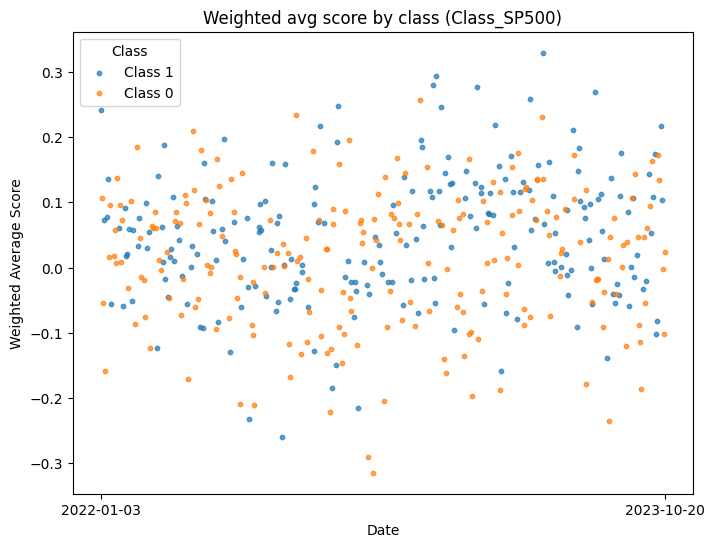

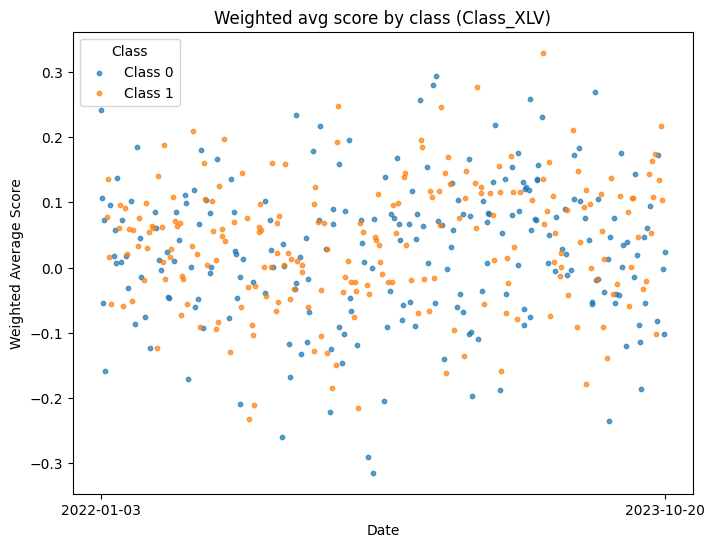

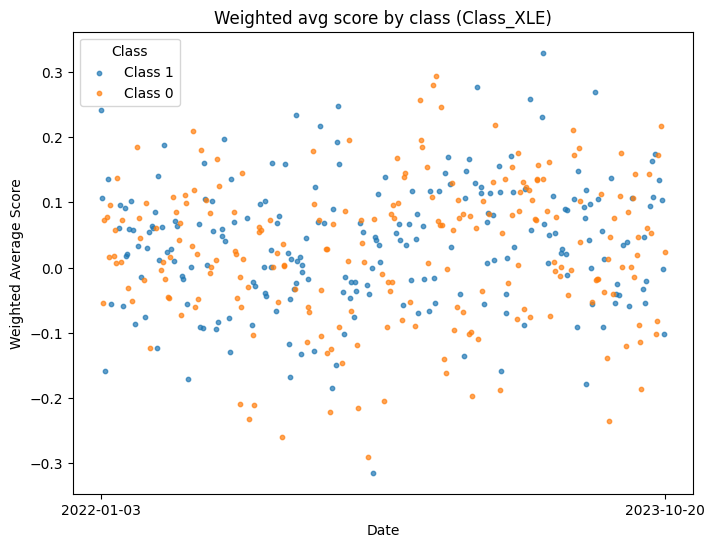

In [ ]:
for class_name in ['Class_SP500', 'Class_XLV', 'Class_XLE']:

    scaled_data['Date'] = pd.to_datetime(scaled_data['Date'])

    plt.figure(figsize=(8, 6))

    for class_value in scaled_data[class_name].unique():
        class_data = scaled_data[scaled_data[class_name] == class_value]
        plt.scatter(class_data['Date'], class_data['weighted_avg_score'],
                    label=f"Class {class_value}", alpha=0.7, s=10)

    plt.title(f"Weighted avg score by class ({class_name})")
    plt.xlabel("Date")
    plt.ylabel("Weighted Average Score")
    plt.legend(title="Class")

    plt.xticks([scaled_data['Date'].min(), scaled_data['Date'].max()],
               [scaled_data['Date'].min().strftime('%Y-%m-%d'), scaled_data['Date'].max().strftime('%Y-%m-%d')])

    plt.show()

There actually seems to be slighlty more horizontal clusters with the specific indices so we will continue to explore wuth all three for now.

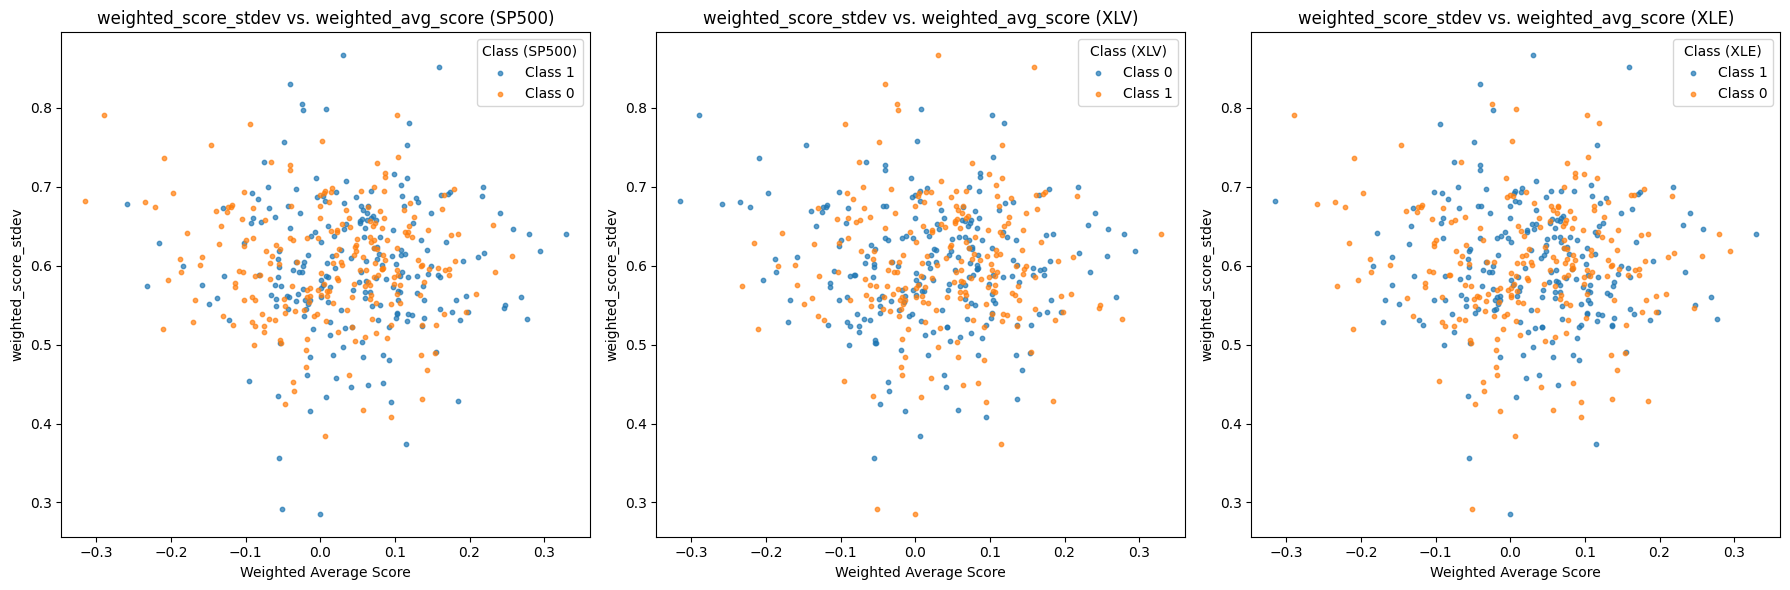

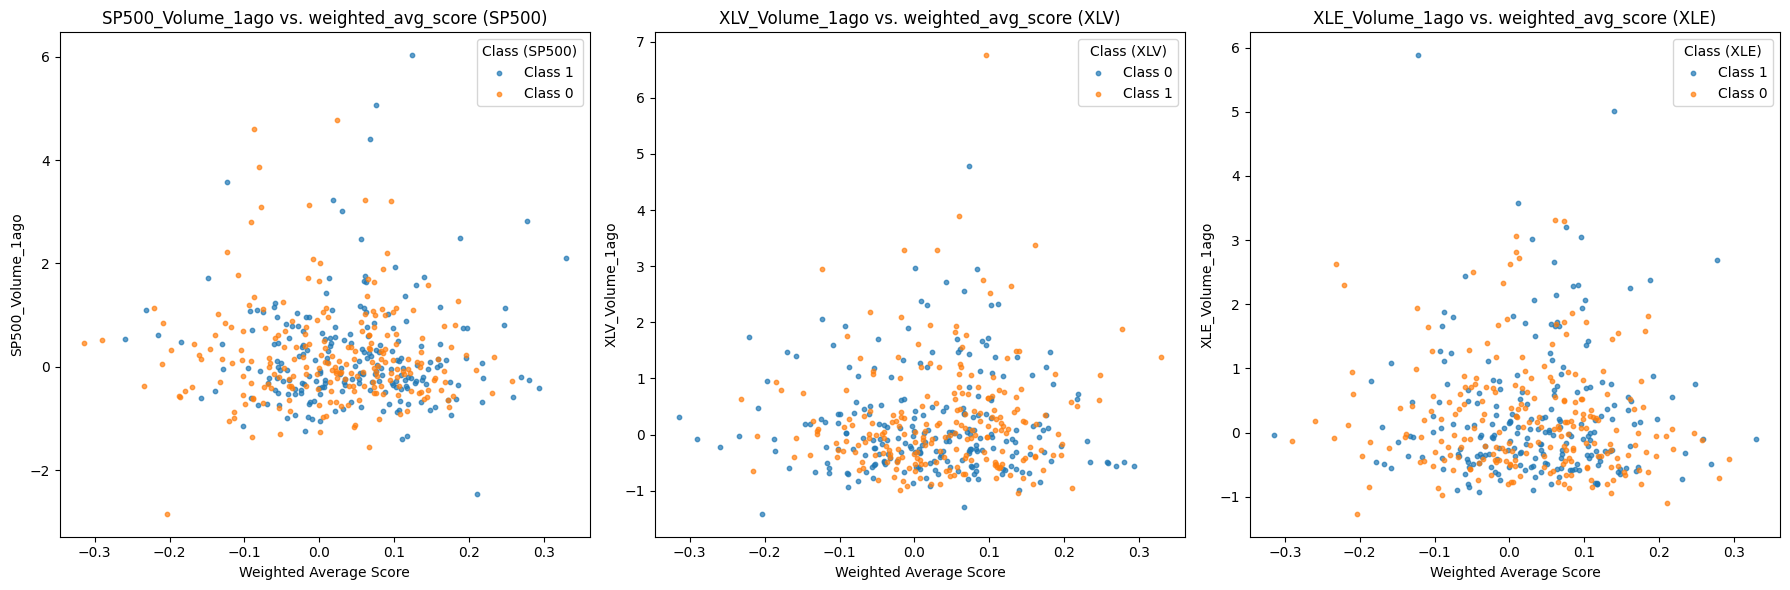

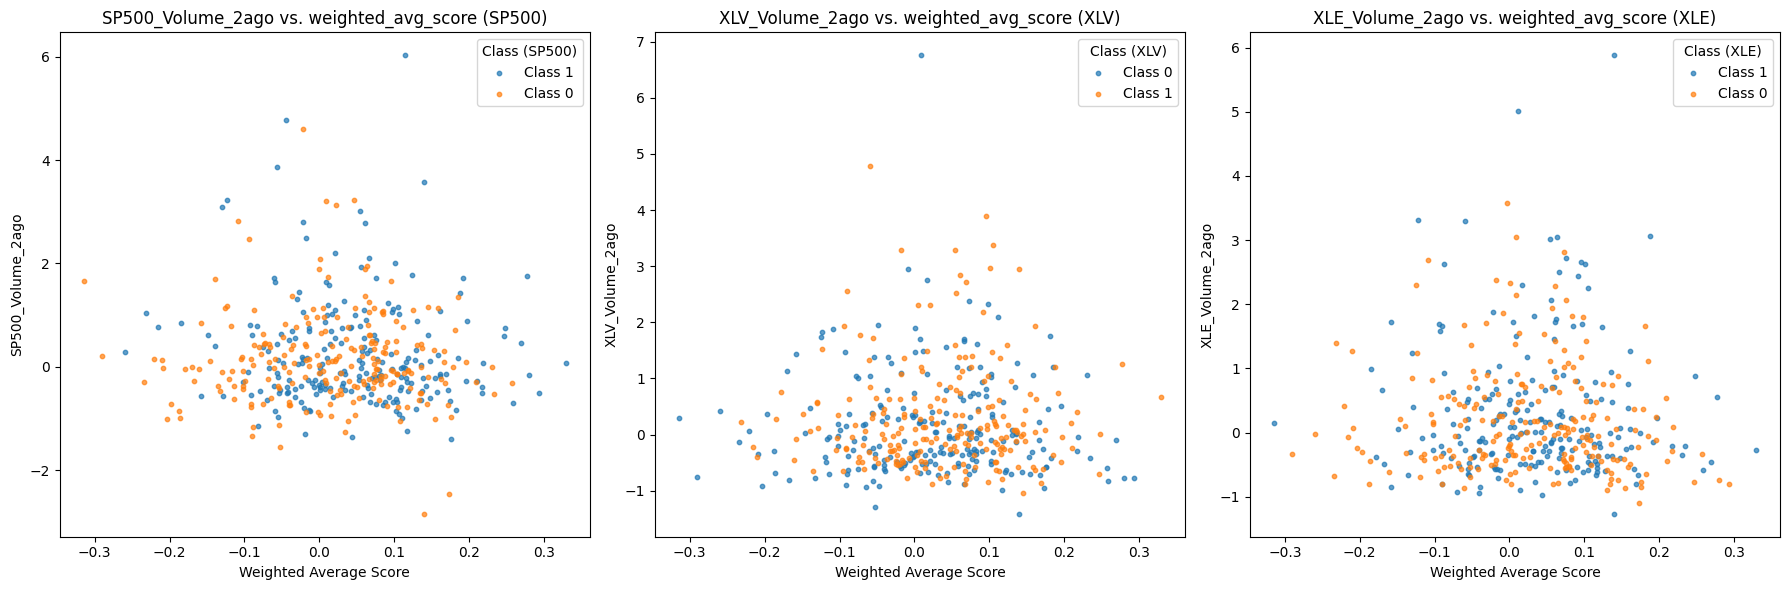

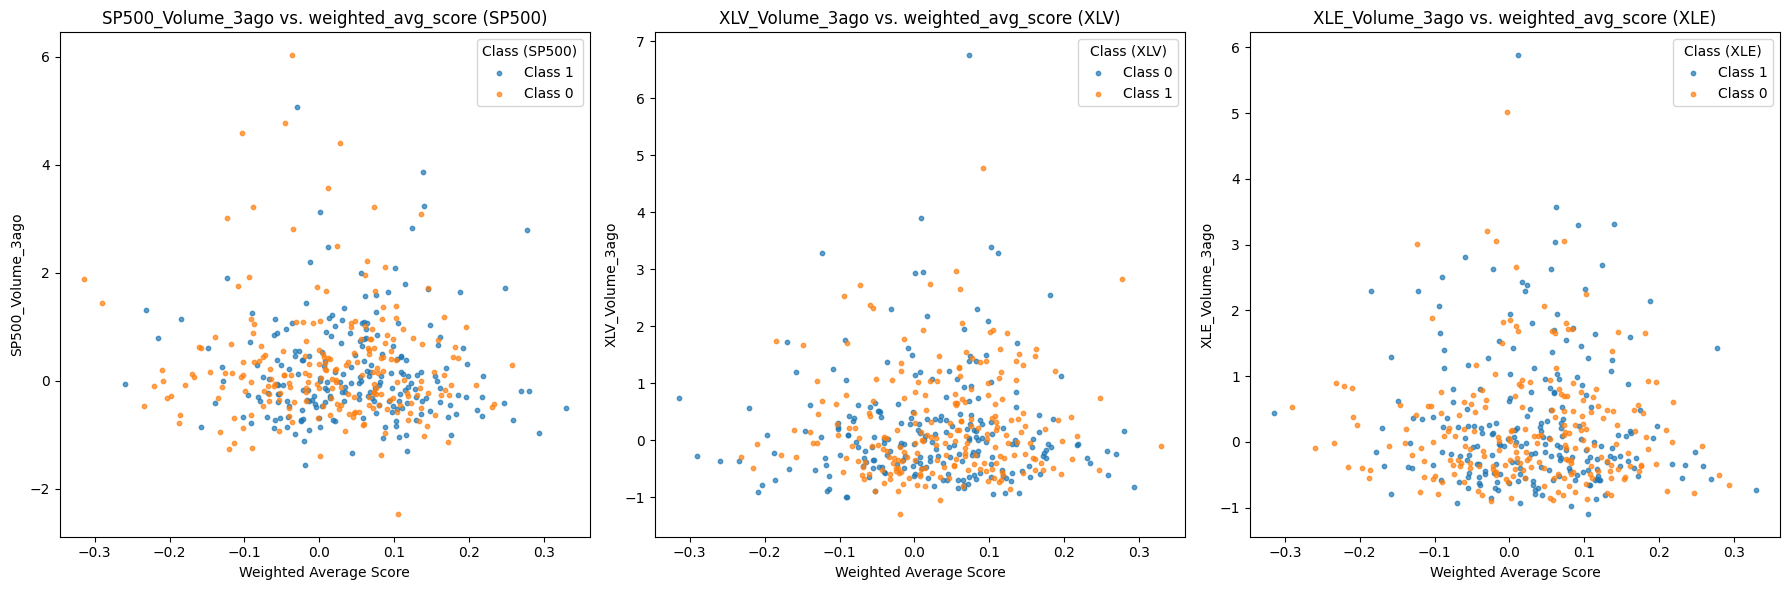

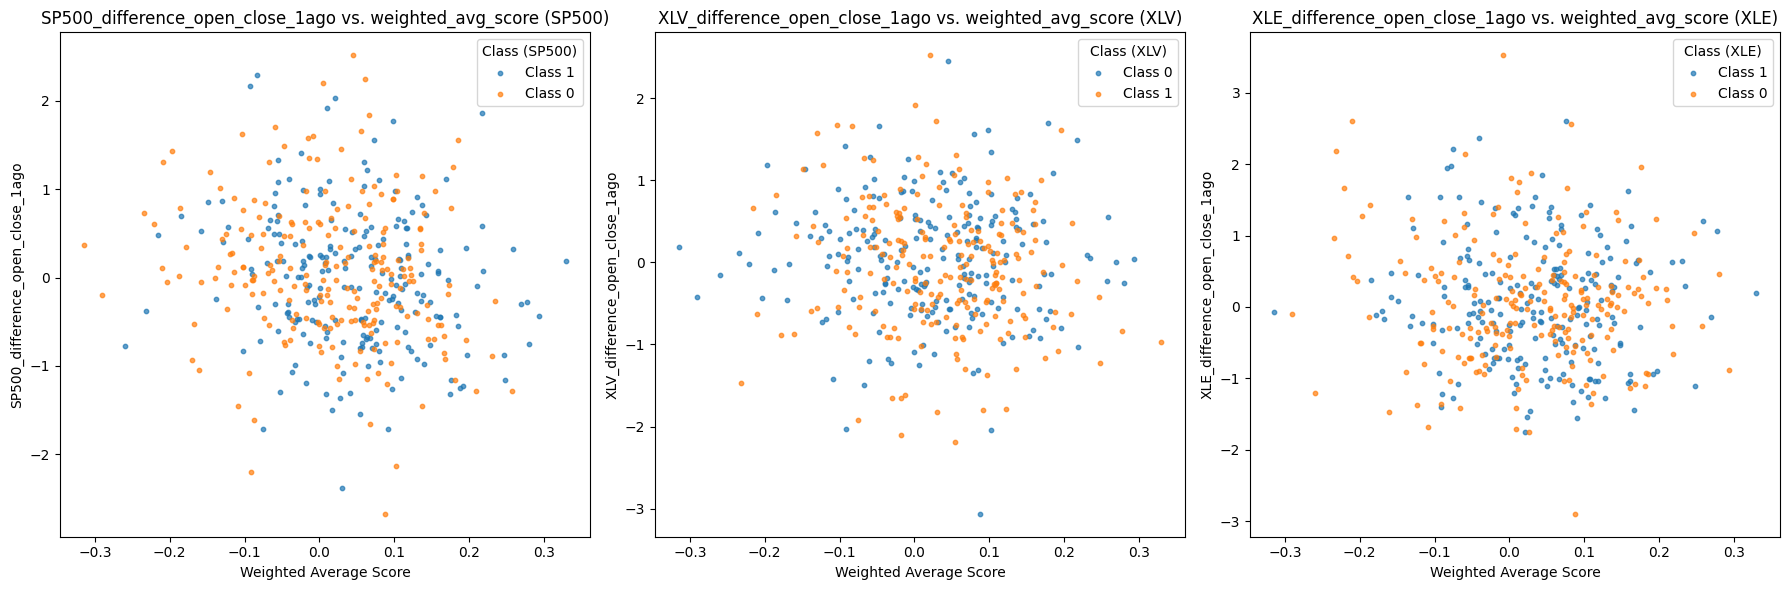

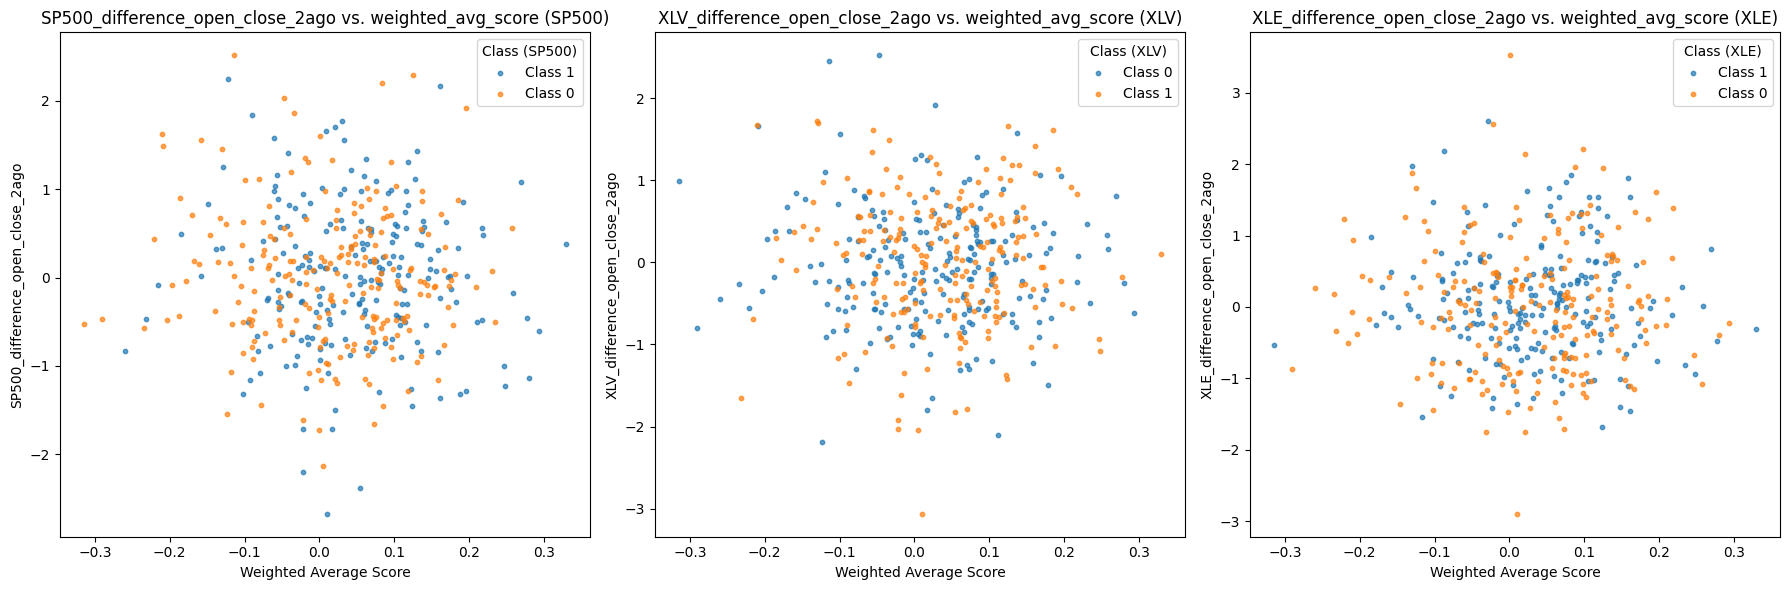

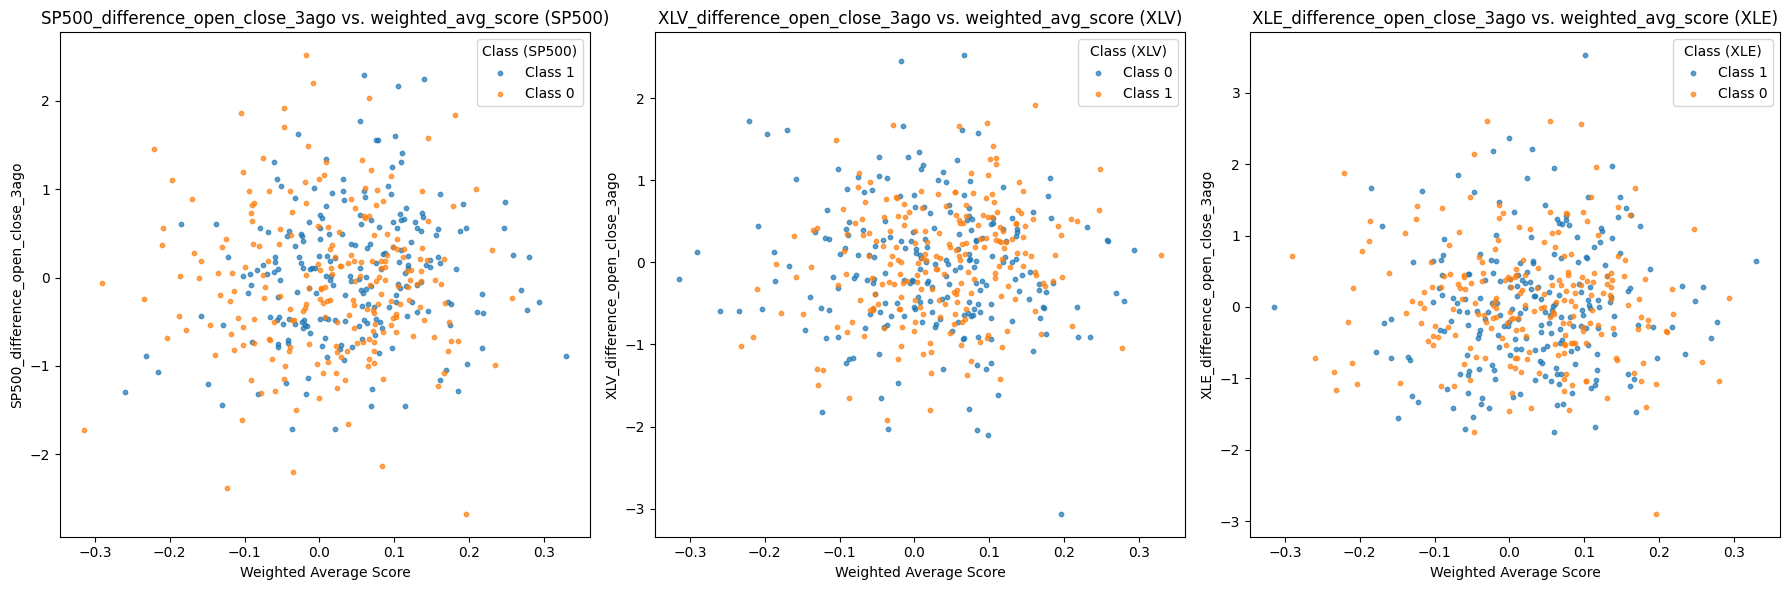

In [ ]:
import matplotlib.gridspec as gridspec

SP500_to_plot = ['weighted_score_stdev', 'SP500_Volume_1ago', 'SP500_Volume_2ago', 'SP500_Volume_3ago', 'SP500_difference_open_close_1ago', 'SP500_difference_open_close_2ago', 'SP500_difference_open_close_3ago']

replacements = ["SP500", "XLV", "XLE"]

for original_col in SP500_to_plot:
    fig = plt.figure(figsize=(18, 6))
    spec = gridspec.GridSpec(1, 3, figure=fig)

    for idx, replacement in enumerate(replacements):
        col = original_col.replace("SP500", replacement)
        class_column = f"Class_{replacement}"

        ax = fig.add_subplot(spec[0, idx])

        for class_value in scaled_data[class_column].unique():
            class_data = scaled_data[scaled_data[class_column] == class_value]
            ax.scatter(class_data['weighted_avg_score'], class_data[col],
                       label=f"Class {class_value}", alpha=0.7, s=10)

        ax.set_title(f"{col} vs. weighted_avg_score ({replacement})")
        ax.set_xlabel("Weighted Average Score")
        ax.set_ylabel(f"{col}")
        ax.legend(title=f"Class ({replacement})")

    plt.tight_layout()
    plt.show()

We don't get extraoridnary insight from these plots. We can still see that the weighted average sentiment score seem slighlty more correlated with other features for the XLV and XLE classes than for S&P500, so we will keep the three classifications and create three baseline models (we will then determine if we think that there is a significantly higher potential in predicting those classes than the S&P 500).

We also observe that the three lagged volumes seem to give similar plots, so we might consider combining them to simplify our feature space.

We decide, after this step, that we won't use the lagged Open prices, as they really seem to not give any valuable information (we can't identify any pattern at all when plotted against the weighted average score).


We thus pursue our EDA with a correlation matrix among the features we seek to use as predictors.

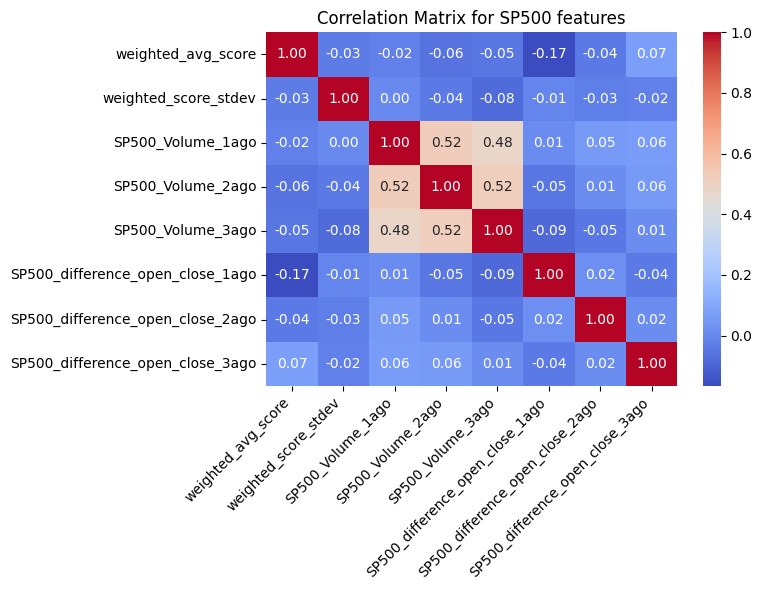

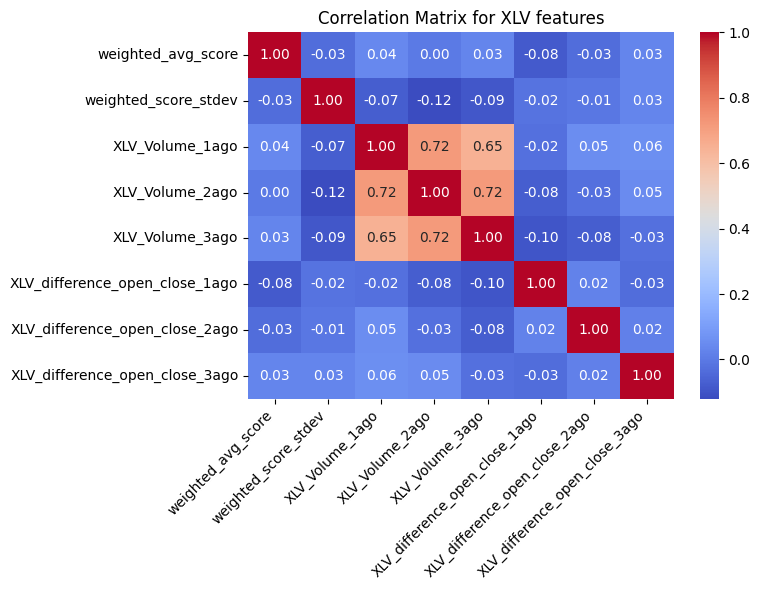

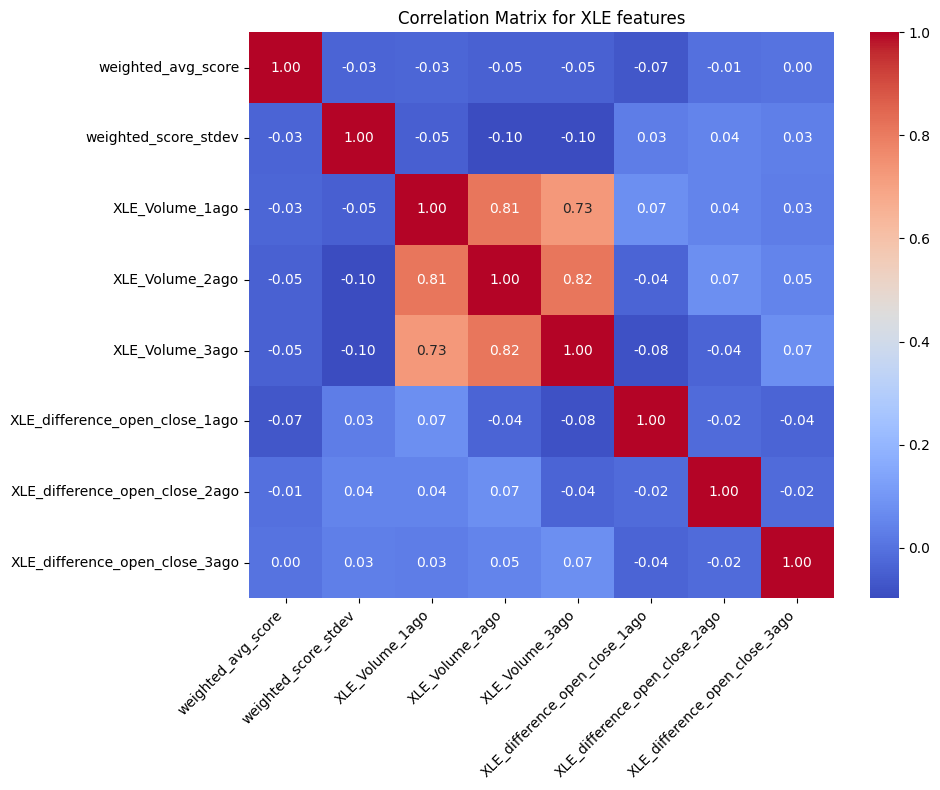

In [ ]:
sp500_columns = ['weighted_avg_score', 'weighted_score_stdev', 'SP500_Volume_1ago', 'SP500_Volume_2ago', 'SP500_Volume_3ago', 'SP500_difference_open_close_1ago', 'SP500_difference_open_close_2ago', 'SP500_difference_open_close_3ago']

corr_matrix_SP500 = scaled_data[sp500_columns].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_SP500, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title(f'Correlation Matrix for SP500 features')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


xlv_columns = ['weighted_avg_score', 'weighted_score_stdev', 'XLV_Volume_1ago', 'XLV_Volume_2ago', 'XLV_Volume_3ago', 'XLV_difference_open_close_1ago', 'XLV_difference_open_close_2ago', 'XLV_difference_open_close_3ago']

corr_matrix_XLV = scaled_data[xlv_columns].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_XLV, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title(f'Correlation Matrix for XLV features')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


xle_columns = ['weighted_avg_score', 'weighted_score_stdev', 'XLE_Volume_1ago', 'XLE_Volume_2ago', 'XLE_Volume_3ago', 'XLE_difference_open_close_1ago', 'XLE_difference_open_close_2ago', 'XLE_difference_open_close_3ago']

corr_matrix_XLE = scaled_data[xle_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_XLE, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title(f'Correlation Matrix for XLE features')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

(Wow!) there is a great positive correlation between the lagged volumes for all three classes, we thus combine these three columns into one averaged value of the volumes in the three previous days.

In [ ]:
scaled_data['SP500_Volume_past3'] = scaled_data[['SP500_Volume_1ago', 'SP500_Volume_2ago', 'SP500_Volume_3ago']].mean(axis=1)
scaled_data['XLV_Volume_past3'] = scaled_data[['XLV_Volume_1ago', 'XLV_Volume_2ago', 'XLV_Volume_3ago']].mean(axis=1)
scaled_data['XLE_Volume_past3'] = scaled_data[['XLE_Volume_1ago', 'XLE_Volume_2ago', 'XLE_Volume_3ago']].mean(axis=1)

## Baseline Models

We start by training very simple decision tree classifiers to determine if sentiments analysis has a stronger impact on one of the indices that we are looking at.

We also drop the rows containing empty cells (those were created by adding our lagged features) to make sure we don't encounter any issue during training.

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

scaled_data = scaled_data.dropna()


# S&P 500

SP500_features = scaled_data[['weighted_avg_score', 'weighted_score_stdev']]
SP500_y = scaled_data['Class_SP500']
X_train_SP500, X_test_SP500, y_train_SP500, y_test_SP500 = train_test_split(SP500_features, SP500_y, test_size=0.2, random_state=109)

SP500_dt = DecisionTreeClassifier(random_state=109)

param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'min_samples_split': [2, 5, 10, 20, 50],
    'min_samples_leaf': [1, 2, 5, 10, 20],
    'max_depth': [None, 5, 10, 15, 20, 30],
}

grid_search = GridSearchCV(
    estimator=SP500_dt,
    param_grid=param_grid,
    cv=10,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train_SP500, y_train_SP500)

print("SP500: Best Cross-Validation Accuracy:", grid_search.best_score_)

best_model_SP500_dt = grid_search.best_estimator_
y_pred_SP500 = best_model_SP500_dt.predict(X_test_SP500)

print("SP500: Test Set Accuracy:", accuracy_score(y_test_SP500, y_pred_SP500))

feature_importances = pd.DataFrame({
    'Feature': SP500_features.columns,
    'Importance': best_model_SP500_dt.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(feature_importances)



# XLV

XLV_features = scaled_data[['weighted_avg_score', 'weighted_score_stdev']]
XLV_y = scaled_data['Class_XLV']
X_train_XLV, X_test_XLV, y_train_XLV, y_test_XLV = train_test_split(XLV_features, XLV_y, test_size=0.2, random_state=109)

XLV_dt = DecisionTreeClassifier(random_state=109)

grid_search = GridSearchCV(
    estimator=XLV_dt,
    param_grid=param_grid,
    cv=10,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train_XLV, y_train_XLV)

print("\n\nXLV: Best Cross-Validation Accuracy:", grid_search.best_score_)

best_model_XLV_dt = grid_search.best_estimator_
y_pred_XLV = best_model_XLV_dt.predict(X_test_XLV)

print("XLV: Test Set Accuracy:", accuracy_score(y_test_XLV, y_pred_XLV))

feature_importances = pd.DataFrame({
    'Feature': XLV_features.columns,
    'Importance': best_model_XLV_dt.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(feature_importances)



# XLE

XLE_features = scaled_data[['weighted_avg_score', 'weighted_score_stdev']]
XLE_y = scaled_data['Class_XLE']
X_train_XLE, X_test_XLE, y_train_XLE, y_test_XLE = train_test_split(XLE_features, XLE_y, test_size=0.2, random_state=109)

XLE_dt = DecisionTreeClassifier(random_state=109)

param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'min_samples_split': [2, 5, 10, 20, 50],
    'min_samples_leaf': [1, 2, 5, 10, 20],
    'max_depth': [None, 5, 10, 15, 20, 30],
}

grid_search = GridSearchCV(
    estimator=XLE_dt,
    param_grid=param_grid,
    cv=10,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train_XLE, y_train_XLE)

print("\n\nXLE: Best Cross-Validation Accuracy:", grid_search.best_score_)

best_model_XLE_dt = grid_search.best_estimator_
y_pred_XLE = best_model_XLE_dt.predict(X_test_XLE)

print("XLE: Test Set Accuracy:", accuracy_score(y_test_XLE, y_pred_XLE))

feature_importances = pd.DataFrame({
    'Feature': XLE_features.columns,
    'Importance': best_model_XLE_dt.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(feature_importances)



print("\nClassification Report for SP500:\n", classification_report(y_test_SP500, y_pred_SP500))


SP500: Best Cross-Validation Accuracy: 0.5810084033613446
SP500: Test Set Accuracy: 0.5113636363636364
                Feature  Importance
0    weighted_avg_score    0.574267
1  weighted_score_stdev    0.425733


XLV: Best Cross-Validation Accuracy: 0.5861344537815125
XLV: Test Set Accuracy: 0.42045454545454547
                Feature  Importance
0    weighted_avg_score    0.586935
1  weighted_score_stdev    0.413065


XLE: Best Cross-Validation Accuracy: 0.5490756302521008
XLE: Test Set Accuracy: 0.5909090909090909
                Feature  Importance
0    weighted_avg_score    0.592161
1  weighted_score_stdev    0.407839

Classification Report for SP500:
               precision    recall  f1-score   support

           0       0.55      0.54      0.55        48
           1       0.46      0.47      0.47        40

    accuracy                           0.51        88
   macro avg       0.51      0.51      0.51        88
weighted avg       0.51      0.51      0.51        88



We see that, perhaps quite surprisingly, the accuracy we get for the S&P500 is in between the two indices, and is only slightly better than what we would get with a random classifier (which is not great). We see that predicting XLV gives singifictanly worse results on the testing data, and the performance for XLE is somewhat clearly better.

It seems, looking at the best cv accuracies, that these differences come from  better generalization when predicitng the XLE prices, rather than the ETFs being more correlated with our sentiment analysis than the S&P500.

This answers one of the questions that we had: given our discreptancies it doesnt seem that using more specific index would allow us to have a better performing model - so as we use general set of headlines (not industry specific) we decided to stick with S&P 500

Another interestnig observation is that for S&P 500 data the standard deviation of sentiment is a more important feature than for the other indices,  this suggest that the range of results and how much the "most negative/positive articles skew the sentiment is crucial.

## Final Model

We now train a random forest model on the S&P 500 classification data. We perform a significant parameter fine tuning while trying to keep a mangeable notebook in terms of computational ressources. As we recommended, we included as many features as we have at our disposal (after eleminating the highly correlated ones, above in the notebook).

In [ ]:
from sklearn.ensemble import RandomForestClassifier

features = ['weighted_avg_score', 'weighted_score_stdev', 'SP500_difference_open_close_1ago','SP500_difference_open_close_2ago','SP500_difference_open_close_3ago', 'SP500_Volume_past3']

X = scaled_data[features]
y = scaled_data['Class_SP500']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=109)

rf = RandomForestClassifier(random_state=109)

# Parameter Grid
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [None, 10, 25],
    'min_samples_leaf': [1, 5, 10],
    'criterion': ['gini', 'entropy']
}


grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=10,
    scoring='accuracy',
    n_jobs=-1
)


grid_search.fit(X_train, y_train)

# Best model
best_rf = grid_search.best_estimator_

y_pred = best_rf.predict(X_test)

print("Best Cross-Validation Accuracy:", grid_search.best_score_)
print("Test Set Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Feature Importances
feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': best_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importances)

Best Cross-Validation Accuracy: 0.5457983193277312
Test Set Accuracy: 0.48863636363636365
Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.46      0.49        48
           1       0.45      0.53      0.48        40

    accuracy                           0.49        88
   macro avg       0.49      0.49      0.49        88
weighted avg       0.50      0.49      0.49        88

Feature Importances:
                            Feature  Importance
0                weighted_avg_score    0.218916
4  SP500_difference_open_close_3ago    0.194859
3  SP500_difference_open_close_2ago    0.160679
2  SP500_difference_open_close_1ago    0.155802
1              weighted_score_stdev    0.136375
5                SP500_Volume_past3    0.133370


We see that we have fairly poor results. Although this was expected (if it was so easy to predict stock market prices, hedge fund wouldn't make so much money), we still want to push further and try to understand what is happening.

We see that 1) the best cv accuracy score is much higher than the test accuracy score that we get and that 2) the feature importance is almost evenly distributed among the features we used, with a slight excpetion for the sentiment's weighted_avg_score that is slighly more important than others.

From observation 2, we can induce that most of our features have a very little predictive power; this would also explain our hard-to-interpret plots in our earlier EDA. We are thus proned to perform a simple sanity check and train a random forest with only weighted_avg_score as predictor.

In [ ]:
features = ['weighted_avg_score'] #only one

X = scaled_data[features]
y = scaled_data['Class_SP500']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=109)

rf = RandomForestClassifier(random_state=109)

param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [None, 10, 40],
    'min_samples_leaf': [1, 5, 10],
    'criterion': ['gini', 'entropy' ]
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=10,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

y_pred = best_rf.predict(X_test)

print("Best Cross-Validation Accuracy:", grid_search.best_score_)
print("Test Set Accuracy:", accuracy_score(y_test, y_pred))

Best Cross-Validation Accuracy: 0.5401680672268907
Test Set Accuracy: 0.5340909090909091


We got a great improvement (as now we are above the level of a random classifier) We can see that now the model not necessarly overfits (as the CV and test performance) are similar, but more than it just struggles to genzralize and predict data in the suffiecient way.

We thus try another approach, using boosting (and including all of our available features again), to explore this problem more. We use XGBoost as recommended and finetune it as we usually do, with a parameters grid.



In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

features = ['weighted_avg_score', 'weighted_score_stdev', 'SP500_difference_open_close_1ago','SP500_difference_open_close_2ago','SP500_difference_open_close_3ago', 'SP500_Volume_past3']
X = scaled_data[features]
y = scaled_data['Class_SP500']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=109)

# XGBoost classifier
xgb_clf = xgb.XGBClassifier(
    random_state=109,
    eval_metric="logloss"
)

# Parameter Grid
param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

grid_search_xgb = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    cv=10,
    scoring='accuracy',
    n_jobs=-1
)

grid_search_xgb.fit(X_train, y_train)

best_xgb = grid_search_xgb.best_estimator_

y_pred_xgb = best_xgb.predict(X_test)

print("Best Cross-Validation Accuracy:", grid_search_xgb.best_score_)
print("Test Set Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))

feature_importances_xgb = pd.DataFrame({
    'Feature': features,
    'Importance': best_xgb.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importances (XGBoost):")
print(feature_importances_xgb)


Best Cross-Validation Accuracy: 0.5633613445378152
Test Set Accuracy: 0.4772727272727273
Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.40      0.45        48
           1       0.44      0.57      0.50        40

    accuracy                           0.48        88
   macro avg       0.49      0.49      0.48        88
weighted avg       0.49      0.48      0.47        88

Feature Importances (XGBoost):
                            Feature  Importance
4  SP500_difference_open_close_3ago    0.193606
0                weighted_avg_score    0.182478
3  SP500_difference_open_close_2ago    0.163975
5                SP500_Volume_past3    0.163377
2  SP500_difference_open_close_1ago    0.157902
1              weighted_score_stdev    0.138662


This does not seem to improve our results. We see a reasonnable increase on the CV data, but not on the test data.

Once again, we see that all features are almost equally important (except for the average weighted score that is again slighlty higher). So we try to isolate it and retrain a boosting classifier with only average weighted score.

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report


features = ['weighted_avg_score']
X = scaled_data[features]
y = scaled_data['Class_SP500']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=109)

# XGBoost classifier
xgb_clf = xgb.XGBClassifier(
    random_state=109,
    eval_metric="logloss"
)

# Parameter Grid
param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 1.0],
    'colsample_bytree': [0.6, 1.0]
}

grid_search_xgb = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    cv=10,
    scoring='accuracy',
    n_jobs=-1
)

grid_search_xgb.fit(X_train, y_train)

best_xgb = grid_search_xgb.best_estimator_

y_pred_xgb = best_xgb.predict(X_test)

print("Best Cross-Validation Accuracy:", grid_search_xgb.best_score_)
print("Test Set Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))

feature_importances_xgb = pd.DataFrame({
    'Feature': features,
    'Importance': best_xgb.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importances (XGBoost):")
print(feature_importances_xgb)


Best Cross-Validation Accuracy: 0.5632773109243697
Test Set Accuracy: 0.48863636363636365
Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.40      0.46        48
           1       0.45      0.60      0.52        40

    accuracy                           0.49        88
   macro avg       0.50      0.50      0.49        88
weighted avg       0.50      0.49      0.48        88

Feature Importances (XGBoost):
              Feature  Importance
0  weighted_avg_score         1.0


This shows tharr using xgboost had the best performance on the CV data, but significantly worse on the Test model. This supports the idea we see across the model - that stock market is really hard to predict and that using statistical tools doesnt lead to clear improvement on the testing data.  

## Conclusion

Thus, depsite our research and fine tuning efforts, our models did not reach satisfying performance levels.

In the features that we explored for classification, we found that only the sentiment analysis had somehwat of a convincing predictive power.

The next steps for this therefore include:
- looking even closer at the sentiment analysis and test other ways of extracting features from it (potentially by turning it into various sentiment classes, instead of our simple positive, negative, neutral approach)
- looking up research on trading algorithms and stock market predictors, to see if there is any useful feature to be extracted from the S&P500 data that we have
- (if possible, as we alreayd tried at the beginning with Reuters and our webscraping scripts kept on getting blocked), extend our headlines dataset, potentially with more opiniated sources


# Regression problem

We now try to predict, using regression, the precise value (within a range) of the index price.

## EDA on the new dataset (Regression)

In [ ]:
import pandas as pd

#  unscaled_data
unscaled_data = pd.read_csv("new_sp.csv")

unscaled_data['Date'] = pd.to_datetime(unscaled_data['Date'])
stats_per_day['date'] = pd.to_datetime(stats_per_day['date'])

merged_data = pd.merge(
    unscaled_data,
    stats_per_day,
    left_on='Date',
    right_on='date',
    how='left'
)

if 'date' in merged_data.columns:
    merged_data.drop(columns=['date'], inplace=True)
else:
    print("'date' column not found in merged_data. Skipping drop operation.")

merged_data.to_csv('unscaled_data_with_stats_per_day.csv', index=False)

print("Merged data saved to 'unscaled_data_with_stats_per_day.csv'")

print("Shape of the merged data:", merged_data.shape)
print("Data types in merged data:\n", merged_data.dtypes)
print("Summary statistics of the merged data:\n", merged_data.describe())

shape_info = pd.DataFrame({"Rows": [merged_data.shape[0]], "Columns": [merged_data.shape[1]]})
dtypes_info = pd.DataFrame(merged_data.dtypes, columns=["Data Type"])
summary_statistics = merged_data.describe()

shape_info.to_csv("shape_info.csv", index=False)
dtypes_info.to_csv("dtypes_info.csv")
summary_statistics.to_csv("summary_statistics.csv")

print("Shape, data types, and summary statistics saved to CSV files.")

if 'weighted_avg_score' in merged_data.columns:
    weighted_avg_summary = merged_data["weighted_avg_score"].describe()
    print("Summary Statistics for Weighted Average Sentiment Score:\n", weighted_avg_summary)
    weighted_avg_summary.to_csv("weighted_avg_score_summary.csv", header=True)
    print("Summary statistics for 'weighted_avg_score' saved to 'weighted_avg_score_summary.csv'.")
else:
    print("'weighted_avg_score' column not found in merged_data. Skipping summary statistics.")


Merged data saved to 'unscaled_data_with_stats_per_day.csv'
Shape of the merged data: (453, 11)
Data types in merged data:
 Date                    datetime64[ns]
Open                           float64
Close                          float64
High                           float64
Low                            float64
Volume                           int64
diffrence_open/close           float64
diffrence_high/low             float64
day_of_week                      int64
weighted_avg_score             float64
weighted_score_stdev           float64
dtype: object
Summary statistics of the merged data:
                                 Date         Open        Close         High  \
count                            453   453.000000   453.000000   453.000000   
mean   2022-11-26 20:46:05.562913792  4157.141031  4156.800204  4186.344789   
min              2022-01-03 00:00:00  3520.370117  3577.030029  3608.340088   
25%              2022-06-15 00:00:00  3957.179932  3957.250000  3979.199951  

For the Regression models and visualizations we use the merged data since we want acurate numerical predictions for our predicted variables.

Missing values before dropping:
Date                     0
Open                     0
Close                    0
High                     0
Low                      0
Volume                   0
diffrence_open/close     0
diffrence_high/low       0
day_of_week              0
weighted_avg_score      13
weighted_score_stdev    13
dtype: int64
Missing values after dropping:
Date                    0
Open                    0
Close                   0
High                    0
Low                     0
Volume                  0
diffrence_open/close    0
diffrence_high/low      0
day_of_week             0
weighted_avg_score      0
weighted_score_stdev    0
dtype: int64


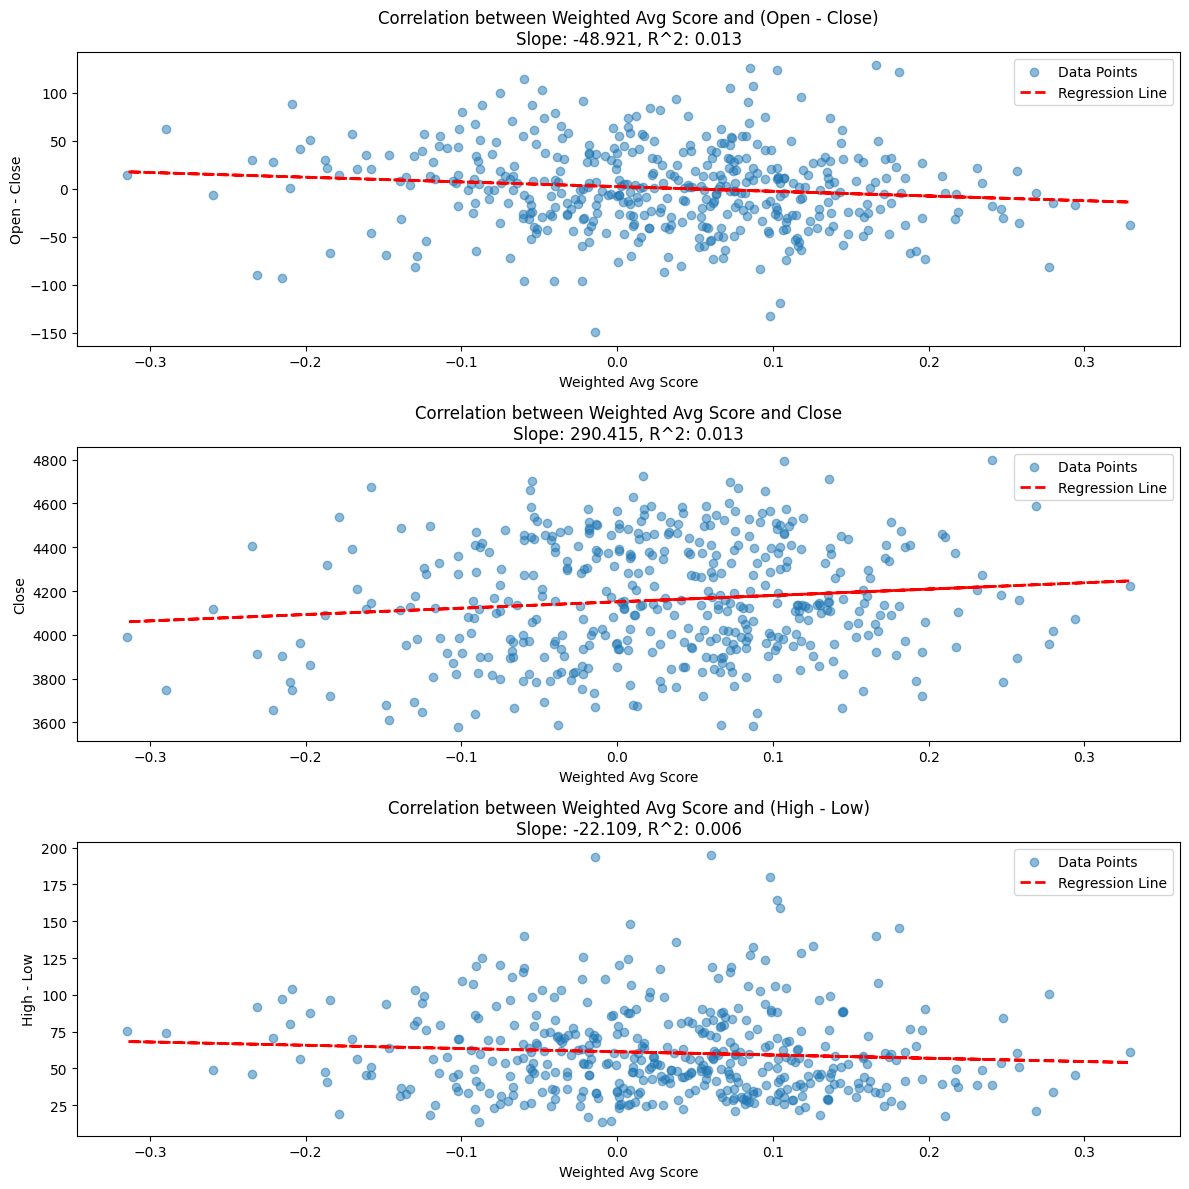

In [ ]:
df = merged_data
print("Missing values before dropping:")
print(df.isna().sum())
df = df.dropna()
print("Missing values after dropping:")
print(df.isna().sum())

def plot_with_regression(x, y, xlabel, ylabel, title, ax):

    ax.scatter(x, y, alpha=0.5, label='Data Points')


    x_reshaped = np.array(x).reshape(-1, 1)
    model = LinearRegression()
    model.fit(x_reshaped, y)
    slope = model.coef_[0]
    intercept = model.intercept_


    y_pred = model.predict(x_reshaped)
    ax.plot(x, y_pred, color='red', linestyle='--', linewidth=2, label='Regression Line')


    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(f"{title}\nSlope: {slope:.3f}, R^2: {model.score(x_reshaped, y):.3f}")


    ax.legend(loc='best')


fig, axs = plt.subplots(3, 1, figsize=(12, 12))


plot_with_regression(df['weighted_avg_score'], df['diffrence_open/close'],
                     'Weighted Avg Score', 'Open - Close',
                     'Correlation between Weighted Avg Score and (Open - Close)', axs[0])

plot_with_regression(df['weighted_avg_score'], df['Close'],
                     'Weighted Avg Score', 'Close',
                     'Correlation between Weighted Avg Score and Close', axs[1])


plot_with_regression(df['weighted_avg_score'], df['diffrence_high/low'],
                     'Weighted Avg Score', 'High - Low',
                     'Correlation between Weighted Avg Score and (High - Low)', axs[2])

plt.tight_layout()


plt.show()


Not finding a clear correlation between these factors on the daily basis, we thought, what if the effect of headlines was not visible on a day to day basis but we needed a longer period of time to see it. That is why we plotted the same data but on a weekly basis instead of a daily basis. Using the same approach but averaging the metrics across each week, we got better graphs that show trends better aligned with the simple regression lines.


<ipython-input-30-aeb9f889b0f0>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['Date'], errors='coerce')


Weekly Resampled Data:
                   Open        Close         High          Low        Volume  \
date                                                                           
2022-01-09  4752.338086  4732.751953  4769.184082  4713.175977  4.375788e+09   
2022-01-16  4684.924023  4686.317969  4709.047949  4638.452051  4.250368e+09   
2022-01-23  4559.750000  4497.634888  4585.104980  4493.047607  4.861102e+09   
2022-01-30  4369.632031  4374.974023  4428.610059  4283.297949  5.577818e+09   
2022-02-06  4507.190039  4525.887891  4549.046094  4472.751953  4.701056e+09   

            diffrence_open/close  diffrence_high/low  weighted_avg_score  
date                                                                      
2022-01-09             19.586133           56.008105            0.041478  
2022-01-16             -1.393945           70.595898            0.053889  
2022-01-23             62.115112           92.057373            0.054472  
2022-01-30             -5.341992         

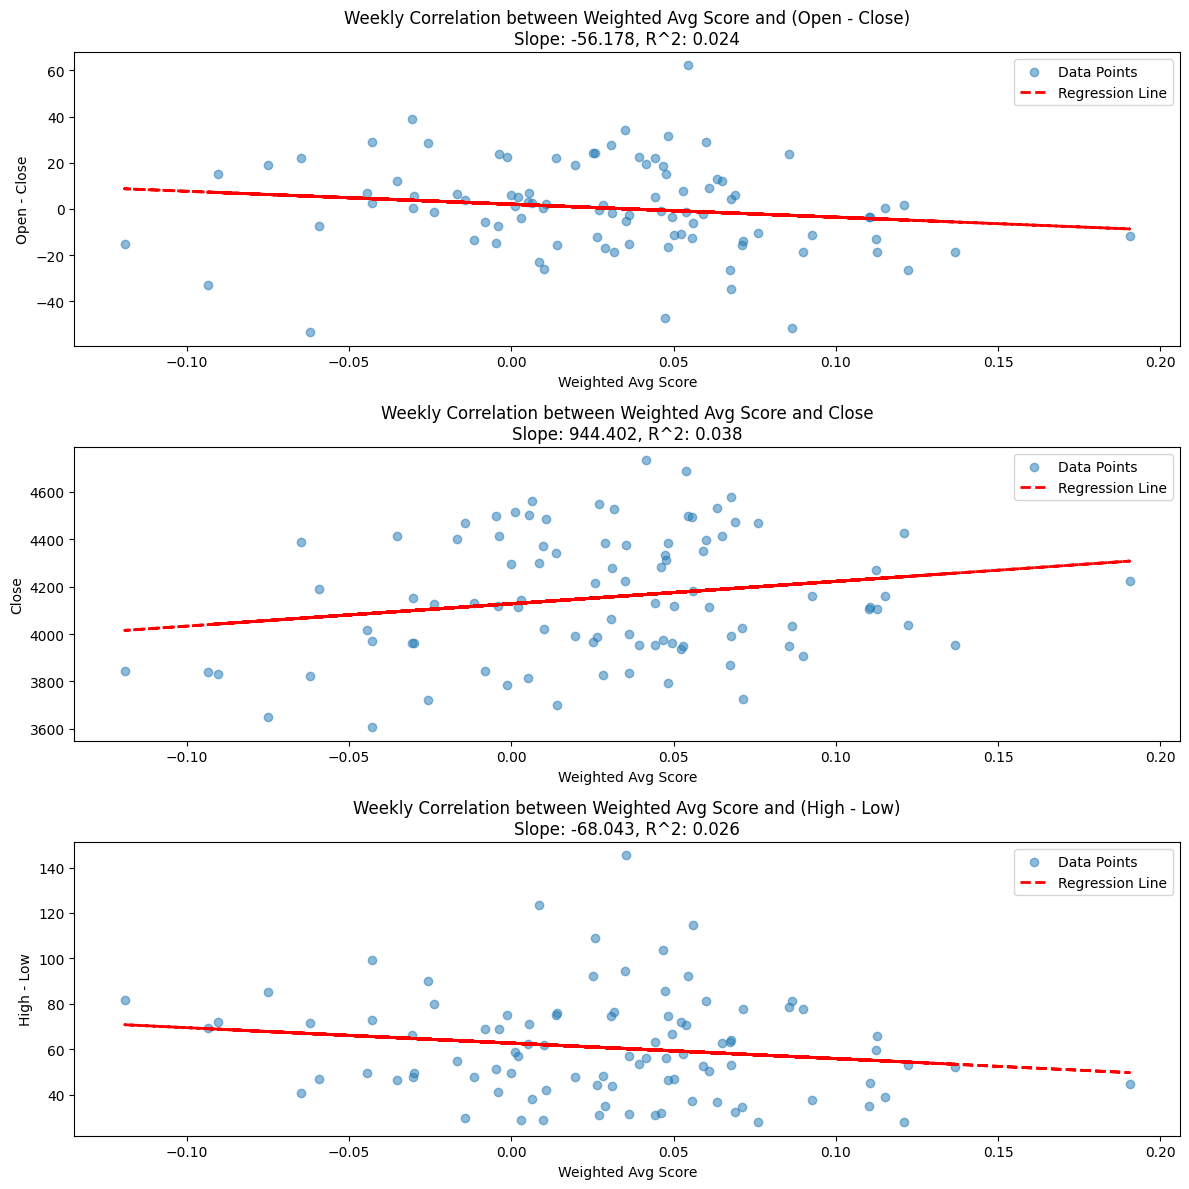

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


df['date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['date'])
df.set_index('date', inplace=True)


numeric_columns = ['Open', 'Close', 'High', 'Low', 'Volume',
                   'diffrence_open/close', 'diffrence_high/low', 'weighted_avg_score']
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')
df = df.dropna(subset=numeric_columns)


resample_columns = ['Open', 'Close', 'High', 'Low', 'Volume',
                    'diffrence_open/close', 'diffrence_high/low', 'weighted_avg_score']
try:
    weekly_df = df[resample_columns].resample('W').mean()
    print("Weekly Resampled Data:")
    print(weekly_df.head())
except Exception as e:
    print("Resampling Error:", e)
    print("Inspecting problematic data...")
    print(df.head())


def plot_with_regression(x, y, xlabel, ylabel, title, ax):

    valid = ~np.isnan(x) & ~np.isnan(y)
    x, y = np.array(x[valid]), np.array(y[valid])


    ax.scatter(x, y, alpha=0.5, label='Data Points')


    x_reshaped = x.reshape(-1, 1)
    model = LinearRegression()
    model.fit(x_reshaped, y)
    slope = model.coef_[0]
    intercept = model.intercept_

    y_pred = model.predict(x_reshaped)
    ax.plot(x, y_pred, color='red', linestyle='--', linewidth=2, label='Regression Line')


    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(f"{title}\nSlope: {slope:.3f}, R^2: {model.score(x_reshaped, y):.3f}")


    ax.legend(loc='best')


fig, axs = plt.subplots(3, 1, figsize=(12, 12))

plot_with_regression(weekly_df['weighted_avg_score'], weekly_df['diffrence_open/close'],
                     'Weighted Avg Score', 'Open - Close',
                     'Weekly Correlation between Weighted Avg Score and (Open - Close)', axs[0])

plot_with_regression(weekly_df['weighted_avg_score'], weekly_df['Close'],
                     'Weighted Avg Score', 'Close',
                     'Weekly Correlation between Weighted Avg Score and Close', axs[1])

plot_with_regression(weekly_df['weighted_avg_score'], weekly_df['diffrence_high/low'],
                     'Weighted Avg Score', 'High - Low',
                     'Weekly Correlation between Weighted Avg Score and (High - Low)', axs[2])


plt.tight_layout()

plt.show()


The most promising ones are the first and the last graphs because:
The closing price increases when the sentiment increases
The difference between highs and lows aka the variations in the prices decreases when the headlines get more neutral which matches what we might expect.

## Baseline Model

We decided to use a Decision tree Regressor since it is simple and a good baseline. The reasoning is the same as in the classification problem.


In measuring accuracy we allow the 1% tolarence - we thing it's impossible to preduct exact number, and for trading if we have a general understading of the values the stock could be in this should be sufficient to achieve good results.

In [ ]:
from sklearn.tree import DecisionTreeRegressor

data = df.copy()
price_column = "Close"
sentiment_column = "weighted_avg_score"
date_column = "Date"

data[date_column] = pd.to_datetime(data[date_column])
data = data.sort_values(by=date_column)

data['Lagged_Price'] = data[price_column].shift(1)
data['Lagged_Sentiment'] = data[sentiment_column].shift(1)

data = data.dropna()

features = ['Lagged_Price', 'Lagged_Sentiment', "day_of_week"]
X = data[features]
y = data[price_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=109, shuffle=False)

dt = DecisionTreeRegressor(random_state=109)

dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

def calculate_accuracy(y_true, y_pred, tolerance=0.01):
    within_tolerance = abs(y_true - y_pred) <= (tolerance * y_true)
    accuracy = within_tolerance.sum() / len(y_true)
    average_accuracy = (1 - abs(y_true - y_pred) / y_true).mean()
    return accuracy, average_accuracy

accuracy, average_accuracy = calculate_accuracy(y_test.values, y_pred)

print(f"Accuracy (within 1% tolerance): {accuracy * 100:.2f}%")
print(f"Average Accuracy: {average_accuracy * 100:.2f}%")

results = X_test.copy()
results['Actual_Price'] = y_test.values
results['Predicted_Price'] = y_pred

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R2 Score: {r2:.2f}")


Accuracy (within 1% tolerance): 51.14%
Average Accuracy: 98.80%
Mean Squared Error: 4557.10
R2 Score: 0.43


Tree is not performing sufficiently well - as we get around 51% of data within 1% tolerance from the actual value. What can we note however, is that including the "day of the week" predictor improved our results here strongly (as when we trained the model without using that predicotr we got around 35% of accuracy). This encourages us to include this predictor in our final model.

## Final model (Regression) - choice and justification

We decided to use Random Forest as it yields good results and we do not need a more complex model for now (as discussed in the meeting with our TF)

We find the results promising and will aim to get it above the 0.6 test score we got on the baseline models

In [ ]:
data = df.copy()

price_column = "Close"
sentiment_column = "weighted_avg_score"
date_column = "Date"
data[date_column] = pd.to_datetime(data[date_column])

data = data.sort_values(by=date_column)

data['Lagged_Price'] = data[price_column].shift(1)
data['Lagged_Sentiment'] = data[sentiment_column].shift(1)

data = data.dropna()


features = ['Lagged_Price', 'Lagged_Sentiment', "day_of_week"]
X = data[features]
y = data[price_column]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=109, shuffle=False)

rf = RandomForestRegressor(n_estimators=100, random_state=109)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

def calculate_accuracy(y_true, y_pred, tolerance=0.01):
    within_tolerance = abs(y_true - y_pred) <= (tolerance * y_true)
    accuracy = within_tolerance.sum() / len(y_true)
    average_accuracy = (1 - abs(y_true - y_pred) / y_true).mean()
    return accuracy, average_accuracy

accuracy, average_accuracy = calculate_accuracy(y_test.values, y_pred)

print(f"Accuracy (within 1% tolerance): {accuracy * 100:.2f}%")
print(f"Average Accuracy: {average_accuracy * 100:.2f}%")

results = X_test.copy()
results['Actual_Price'] = y_test.values
results['Predicted_Price'] = y_pred


mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R2 Score: {r2:.2f}")




Accuracy (within 1% tolerance): 69.32%
Average Accuracy: 99.29%
Mean Squared Error: 1519.04
R2 Score: 0.81


In comparison of those 2 models we can see a clear improvement when using a Random Forrest. We have 69.32% of data within 1% tolerance range (compared with 51% in the Decision Tree). We believe that this results shows promise in performance of the model, and that thanks to the averaging mechanism that the random forrest is based on we achieve much better result then when just having an individual tree.  Here we also see the slight improvement when we include the day of the week (from 67% to 69%). We believe that this result is exciting, as we can capture almost 70% of values correctly.

## Regression Final Model - Conclusions

Overall, our performance on the regression problem seems to be quite satisfactory. We are happy to have achieved a performance of 69.32% at the end.

What does adding day_of_week tell us?
1.  Day_of_week improves performance and thus likely allows us to see latent variables (variable that are not directly observable but can be estimated from other, observable variables)
2.  Including day_of_week improves performance likely because during specific parts of the week fluctuations are higher
3.  For example: Fluctuations during the weekend are most likely comparatively lower than the weekdays - something that cannot be predicted unless the model has access to day_of_week

It is important to acknowledge that this score might seem higher than expected because of the fact that we are allowing for 1% tolerance in our accuracy metric. However, it is important to note that - even in this case - having an accuracy of almost 70% is still a satisfying result that can have practical results. Predicting within 1% of the exact fluctuation - a continuous and extremely hard to predict value can be used in real world models and can give traders an edge over the (very often random) market.



# Final Conclusions:

There are two key takeaways from this project. First, we gained a deeper appreciation for the complexity of the stock market and the challenges in predicting it, even with additional predictors. This helped us understand why, despite the vast resources at their disposal, hedge funds and quant finance teams still struggle to achieve a perfect understanding of the market. If market prediction were straightforward, major companies would consistently generate enormous profits. This reinforced the idea that while data science provides valuable insights, it cannot fully solve deeply complex problems.
Second, we came to appreciate the power of data science and the importance of exploring different tools and approaches. Throughout the project, we experimented with various models, preprocessing techniques, sentiment classifiers, and tools. This experience underscored that data science is not just about implementing and coding models, but about critically evaluating the data we use and the decisions we make throughout the process.
In the end of the day, even with our tolerance rate of 1% our model is proving us with pretty accurate prediction of the stock prices. Noting how complex is the market and how many factors impact it, this is a promising result.



# Future Scope

Developing this analysis here made us appreicate the difficulties within trying to predict stock prices and their development over time. I think what's crucial here, is to acknowledge the complexity of the sector and that it can be hard to fully establish the relations when using very general index and general level of sentiment measured by the headlines.

Potential, fairly hard from computational level, potential implementation would be to track the impact of industry-specific related headlines on industry-specific indexes. It is possibe to use RAG databases, to translate the headlines to vectors, and then by cosine similarity find vectors(sentences) that are related to similar topics and then try to group by the sector and look for establishing connections. I think this approach could be succesful in dealing with the noise in data Currently part of the inefficiency in the model probably comes from the fact that we try to predict the price of an index that captures specific 500 companies based on many headlines which some of them can be completely unrelated. To get more spefic understanding of a sentiment we could also try to access headlines of more industry-specific newspapers/blogs/platforms (potentially trying to scrape from social media as well).

Second way in which this project could be improved is to introduce more predictors to the dataset. So far, we use the previous prices and sentiments, which gives us some information but definitely don't capture the complexity of markets. Other potential data to use would be some macroeconomic indicators - like levels of business and consumer confidence, GDP growth predictors or levels of unemployment.